In [5]:
%matplotlib widget
from sklearn.datasets import make_circles,make_moons, make_blobs, make_gaussian_quantiles
from numpy import random
import numpy as np 
from matplotlib import pyplot as plt
import math
import os 

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


### Utility

#### Kernels

In [6]:
### Kernels 
gaussianKernel = lambda x : (1 / math.sqrt(2 * math.pi)) * np.exp( -(1/2) * np.power(x, 2))

#### Plot utility

In [7]:
# =======================================================================
# Utility function that returns the optimal grid-ratio given the number of
# elements. The optimal size is the minimum of the slack and diagonal angle 
# ========================================================================
def getRatio(length):
    f1 = lambda x, c: (math.ceil(c / x) * x) - c
    f2 = lambda x, c : abs(math.atan(math.pow(x,2)/c) - math.pi/3)
    
    # Calculate the ratio by minimizing the diagonal to 45 degree and the padding  
    area = np.array([f1(col, length) for col in range(1, length+1)])
    diag = np.array([f2(col, length) for col in range(1, length+1)])
    result = area/np.sum(area) if np.sum(area) else area + diag/np.sum(diag) if np.sum(diag) else diag
    
    # Get the ratio based on the optimum
    row = min([(i,e)  for i,e in enumerate(result, start=1)] , key=lambda e: e[1])[0]
    col = math.ceil(length / row)
    
    return (row,col)



# =======================================================================
# Generate a plot between each independent and dependent varaible in  
# the dataset, given a plot function and dataset.
# ========================================================================
def plotGrid(data, target, plot, features=None, title="Grid plot"):
    # Cast to vectors and matrecies
    _Y = np.atleast_2d(target); _X = np.atleast_2d(data);
    
    # Index features if they are not provided for
    features = [i for i in range(_X.shape[1])] if features is None else features
    
    # Calculate dimensions
    row,col = getRatio(_X.shape[1])
    figsize = (3*col,3*row)
   
    fig, axis = plt.subplots(row,col, figsize=figsize, dpi=100, facecolor='w', edgecolor='k')
    for idx, ax in enumerate(axis.ravel()):
        if( idx >= _X.shape[1]): break
        plot(ax, _X[:, idx], _Y, features[idx])
    
    fig.suptitle(title, fontsize=16)
    fig.tight_layout(pad=2.0)
    

    
# =======================================================================
# Factory for plot functions used in the plotGrid function
# ========================================================================
def plotFunction(func, **kwargs): 
    return lambda ax,x,y,feature: func(ax,x,y,feature, **kwargs)  
    
    
    
# =======================================================================
# Plot function for scatterplots
# ========================================================================
def scatterPlot(ax,x,y,f):
    print(x.shape,y.shape)
    ax.scatter(x, y, cmap=plt.cm.coolwarm, s=20, edgecolors='k');
    ax.set_ylabel("Target")
    ax.set_title(f);  

    
    
# =======================================================================
# Plot function for density plots using a given kernel function
# ========================================================================
def distributionPlot(ax,x,y,f, h=0.01, n=100, kernel=gaussianKernel):
    # Samples and domain
    x_i = x.reshape(1,len(x));
    xx = np.linspace(min(x), max(x), n).reshape(n,1)
    
    # Kernel density estimation
    z = (xx - x_i) / h
    y = np.sum(kernel(z), axis=1) / (n*h)
    
    #ax.plot(x, y);
    counts, bins = np.histogram(x_i, bins=10)
    ax.plot(xx, y);
    ax.set_ylabel("Target")
    ax.set_title(f);  
            

### Read data

In [8]:
random_state = np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 200
noisy_circles = make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = make_moons(n_samples=n_samples, noise=0.05)
blobs = make_blobs(n_samples=n_samples, random_state=8)
gaussian = make_gaussian_quantiles(n_samples=n_samples)
no_structure = np.random.rand(n_samples, 2), None

### Data exploration

C:\Users\medde\AppData\Local\Temp\ipykernel_17260\2172467073.py:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(datasets[idx]["data"][:,0], datasets[idx]["data"][:,1], c=datasets[idx]["target"], cmap=plt.cm.coolwarm, s=20, edgecolors='k')


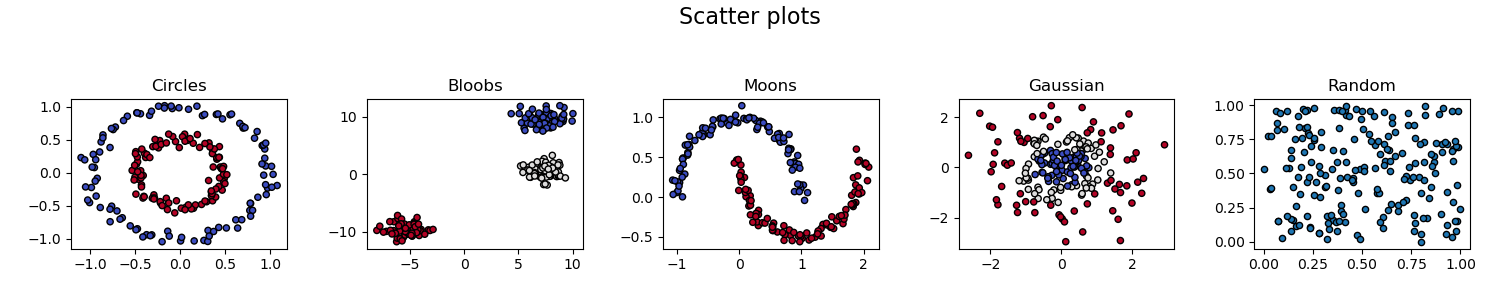

In [9]:
datasets = [
    dict(label= 'Circles', data=noisy_circles[0], target=noisy_circles[1]),
    dict(label = 'Bloobs', data=blobs[0], target=blobs[1]),
    dict(label = 'Moons', data=noisy_moons[0], target=noisy_moons[1]),
    dict(label = 'Gaussian', data=gaussian[0], target=gaussian[1]),
    dict(label = 'Random', data=no_structure[0], target=no_structure[1])
]

#print(datasets[0])

# Calculate dimensions
d = len(datasets)
row,col = getRatio(d)
figsize = (3*col,3*row)

fig, axis = plt.subplots(row,col, figsize=figsize, dpi=100, facecolor='w', edgecolor='k')
for idx, ax in enumerate(axis.ravel()):
    if( idx >= d): break
    ax.scatter(datasets[idx]["data"][:,0], datasets[idx]["data"][:,1], c=datasets[idx]["target"], cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_title(datasets[idx]["label"])
fig.suptitle("Scatter plots", fontsize=16)
fig.tight_layout(pad=2.0)

### PCA

#### Intuition
***
PCA is the "traditional" method for unsupervised dimensionality reduction techniques. It is based on linear principles where the goal is the following:
- Given data points $x_{1},...,x_{n} \in \mathbb{R}^{d}$
- We want to reduce the dimensionality of the data by throwing away dimensions that are not important. 
- Result is set of new data points $y_{1},...,y_{n} \in \mathbb{R}^{l}$ with $l<d$

<strong>Projections</strong>
A linear mapping $P:E \rightarrow E$ between vector spaces is a projection if and only if $P^{2}=P$ Itis an orthogonal projection if and only if it is a projection and $nullspace(P)  \perp image(P)$

<strong>Projection on an l-dimensional subspace</strong>
Want to project on an l-dimension subspace S wit orthonormal basis $v_{1},...,v_{l}$. Define the matrix V with the vector $v_{1},...,v_{l}$ as columns. Then compute the low-dim representation as: $\pi: \mathbb{R}^{d} \rightarrow \mathbb{R}^{l}, x \rightarrow V^{T}x$

#### Theoretical
***
<strong>Maximize the variance</strong>
Given data points $x_{1},...,x_{n} \in \mathbb{R}^{d}$ parameters $l<d$ we want to find the projection $pi_{s}$ on the subspace S such that the variance of the projected points is maximized $max_{s}Var_{l}(\pi_{S}(x))$ For simplicity, let us assume that the data points are centered: </br>
$\quad max_{v_{d} \in \mathbb{R}^{d}, ||v_{d}||=1}Var_{l}(\pi_{S}(x)$</br>
$\quad max_{v_{d}  \in \mathbb{R}^{d}}\sum_{k=1}^{l}\sum_{i=1}^{n} (\pi_{k}(x_{i}))^{2} \quad V^{T}V = I$</br>
$\quad max_{v_{d}  \in \mathbb{R}^{d}}\sum_{k=1}^{l}\sum_{i=1}^{n} (v_{k}^{T}x_{i})^{2} \quad V^{T}V = I$</br>
$\quad max_{v_{d}  \in \mathbb{R}^{d}}\sum_{k=1}^{l}||Xv_{k}||^{2} \quad V^{T}V = I$</br>

This could be solved by utelizing the lagrangian:</br>
$L(V,\lambda) = \sum_{k=1}^{l}||Xv_{k}||^{2} - \lambda_{k}(v_{k}^{T}v_{k} - 1) = \sum_{k=1}^{l} v_{k}^{T}X^{T}Xv_{k}- \lambda_{k}(v_{k}^{T}v_{k} - 1)$</br>
$\frac{dL}{d\alpha} = \sum_{k=1}^{l} 2X^{T}Xv_{k} - 2\lambda_{k} v_{k} \rightarrow X^{T}Xv_{k} = \lambda_{k} v_{k} \quad \forall_{i}$

Thus necessery condition: $v_{k}$ is an eigenvector of $X^{T}X$ Substituting the solution in the original objective function: </br>
$\sum_{k=1}^{l} v_{k}^{T}X^{T}Xv_{k} = \sum_{k=1}^{l} \lambda_{k} v_{k}^{T} v_{k} = \sum_{k=1}^{l} \lambda_{k}$

#### Algorithm
***
- Center the data ponts, that is copute $\hat{x}_{i}=x_{i}-\bar{x} \quad \forall_{i}$
- Compute the $n \times d$ data matrix X with the centered data points $\hat{x}_{i}$ as rows, and the $d \times d$ sample covariance matrix $C=X^{T}X$ 
- Compute eigendecomposition $C=VDV^{T}$
- Define $V$ as the matrix containing the l largest eigenvectors 
- Compute the new data points:
    - view 2: $y_{i} = V^{T}\hat{x}_{i} \in \mathbb{R}^{l}$
    - view 1: $z_{i} = P\hat{x}_{i} + \bar{x} \in \mathbb{R} \quad P=VV^{T}$

In [10]:
# Get data
X = np.genfromtxt('weight-height.csv', delimiter=',', skip_header=1, usecols=(1,2))

# Center data
X_hat = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
X_bar = (X - X_hat)/X_std

# Calculate cov matrix
C = X_bar.T @ X_bar

# Eigen decomposition
D,V = np.linalg.eigh(C)

# Calculate projections
V2 = X_bar @ V
V1 = X_bar @ (V @ V.T)

C:\Users\medde\AppData\Local\Temp\ipykernel_17260\2774376808.py:20: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(datasets[idx]["data"][:,0], datasets[idx]["data"][:,1], cmap=plt.cm.coolwarm, s=20, edgecolors='k')


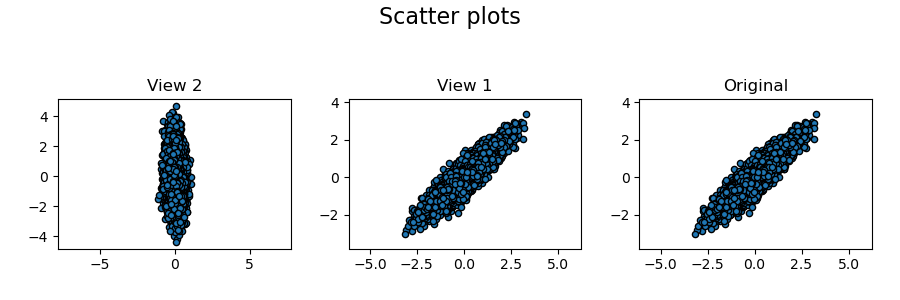

In [11]:
# ============
# Using PCA on gausian data
# ============

datasets = [
    dict(label= 'View 2', data=V2),
    dict(label = 'View 1', data=V1),
    dict(label = 'Original', data=X_bar),
]

# Calculate dimensions
d = len(datasets)
row,col = getRatio(d)
figsize = (3*col,3*row)

# Plot graphs
fig, axis = plt.subplots(row,col, figsize=figsize, dpi=100, facecolor='w', edgecolor='k')
for idx, ax in enumerate(axis.ravel()):
    if( idx >= d): break
    ax.scatter(datasets[idx]["data"][:,0], datasets[idx]["data"][:,1], cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_title(datasets[idx]["label"])
    ax.axis('equal')
fig.suptitle("Scatter plots", fontsize=16)
fig.tight_layout(pad=2.0)

### PCA kernal

### Intuition
***
Now we want to kernelize the PCA algorithm to be able to have non-linear PCA. </br>
Observe:
- PCA uses the covariance matric - and this matric inherently uses the actual coordinates of the data points. 
- So how should we be able to kernelize PCA? 
- The solution will be: There is a right relationship between the covariance matrix and the kernel matrix 

<strong>Covariance matrix vs kernel matrix</strong>
Cosider centered data points: $x_{1},...,x_{n}$, stacked in a data matrix X as rows. Denote the $k-th$ column of the matrix by $X^{(k)}$ Then;
- Corariance matrix is C=$X^{T}X$ because </br>
$\quad Cov_{1,dim}(X^{(k)},X) = \sum_{i=1}^{n} X^{(k)}X^{(l)} = (X^{T}X)_{kl}$ </br>
$\quad$ Also note that because $X^{T}X = \sum_{i=1}^{n} x_{i}x^{t}_{i} \implies Rank(X^{T}X) = d \times d$</br>
- Kernel matrix is </br>
$\quad$  $K=X^{T}X$</br>


Consider: the Singular value decomposition (SVD) of the data matrix $X$ </br>
$X=U\Sigma V$ with $U \in \mathbb{R}^{n \times n}, \Sigma \in \mathbb{R}^{n \times d}, V \in \mathbb{R}^{d \times d}$ Then: </br>
$\quad C = X^{T}X = V \Sigma^{T}\Sigma V$ </br>
$\quad K = X^{T}X = U \Sigma^{T}\Sigma U$ </br>

Can see that C and K are both PSD. The eigenvalues of C and K are pretty much the same ones. The question is not whearher this might also be the case for the eigenvectors. We will also need the inverse of $\Sigma^{\#}$ of the matrix $\Sigma$. For the $n \times d$ matrix $\Sigma$ with non-zero diagonal values: $\sigma_{1},..$ let $\Sigma^{\#}$ be the $d \times n$ matriz with the diagonal values: $\frac{1}{\sigma},..$ Whenever a diagonal entry of $\Sigma$ is 0, we also set the corresponding diagonal value  of $\Sigma^{\#}$ to zero. Then $\Sigma^{\#}\Sigma$ is a $d \times d$ matrix with 1s and 0s on the diagonal. Similarly, the matrix $\Sigma\Sigma^{\#}$ is a $n \times n$ matrix with 1s and os on the diagonal.


<strong> Proposition 1 </strong></br>
***
Consider a set of points $x_1,...,x_n \in \mathbb{R}^{d}$ let $\lambda \neq 0$ be an eigenvalue of K with eigenvector $u=(u_1,...,u_n)^{T} \in \mathbb{R}^{n}$ with $||u||=1$, such that $K\hat{u} = \lambda\hat{u}$ Define: <br/>
$\quad \hat{v} = \frac{1}{\lambda}X^{T}u = \frac{1}{\sqrt{\lambda}} \sum_{j=1}^{n} u_{i} x_{j}$ </br>
Then $\hat{v} \neq 0, ||\hat{v} || = 1$ and $\hat{v}$ is an eigenvector of C with eigenvalues $\lambda$ that is $C\hat{v} = \lambda\hat{v}$

Proof</br>
Consider the Svd of X: $X = U \Sigma V^{T}$ where V are the eigenvectors of C and U the ones of K. Now comput: </br>
$\quad X = U \Sigma V^{T} \quad$    (Now multiply with $\Sigma^{\#}U^{T}$ from the left)
</br> $\quad \implies \Sigma^{\#}U^{T} U \Sigma V^{T}$
</br> $\quad \implies \Sigma^{\#} \Sigma V^{T} \quad$    ($\Sigma^{\#}\Sigma$ is symetric)
</br> $\quad \implies V(\Sigma^{\#} \Sigma) = X^{T} U (\Sigma^{\#})^{T}$</br>
$\Sigma^{\#} \Sigma$ is nearly the identity. In particular, if thei-t singular value $\sigma_{i} \neq 0$ then $\Sigma^{\#} \Sigma$ has entry 1 at the ith position of the diagonal. So it does not change the i-th column of V. Then if u is the ith column of U (that is the ith eigenvector of K) then the ith column of the matrix V coicides with our chosen vector $\hat{v} = \frac{1}{\sigma_{i}}X^{T}u$. Observing $\sigma_{i} = \sqrt{\lambda_{i}}$ shows the statement about eigenvector and eigenvalue. 

The statement about the norm 
$\quad ||\bar{v}||^{2} = || \frac{1}{\sqrt{\lambda}} \sum_{j} u_{i} x_{j}||^{2} = \frac{1}{\lambda} <\sum_{i} u_{i} x_{i}, \sum_{j} u_{j} x_{j}> $ </br>
$\quad =\frac{1}{\lambda} \sum_{i,j} u_{i} u_{j} <x_i,x_j>$</br>
$\quad =\frac{1}{\lambda}\sum_{i,j}u_{i}u_{j}k(x_i,x_j) = \frac{1}{\lambda}u^{T}Ku = \frac{1}{\lambda}u^{T}\lambda u = 1$</br>


<strong> Proposition 2 </strong></br>
***
Assume that the points $x_{i}$ are centered. Let v (with ||v||=1) and $\lambda \neq 0$ be eigenvector and eigenvalues of C, that is $Cv = \lambda v$. Then the vector $\bar{u} = \frac{1}{\sqrt{\lambda}}Xv \in \mathbb{R}^{n}$ is an eigenvector of K with eigenvalue $\lambda$. that is $K\bar{u} = \lambda \bar{u}$ and it has a norm $||u||=1$

Proof: similar to the previous SVD proof, just use this derivation:</br>
$X = U \Sigma V^{T} \quad$ (Now multiply with )</br>
$\implies XV \Sigma^{\#} = U \Sigma V^{T}V\Sigma^{\#}$</br>
$\implies XV \Sigma^{\#} = U \Sigma  \Sigma^{\#} $</br>


<strong> Implications </strong></br>
***
Lets apply the two propositions one after the other: 
- Assume $Cv = \lambda v$ set $\hat{u} = \frac{1}{\sqrt{\lambda}}Xv$. Then by proposition 16, $K \hat{u} = \lambda \hat{u}$. Now set $\hat{v} = \frac{1}{\sqrt{\lambda}}X^{T}\hat{u}$. Then by proposition 15, $C\hat{v} = \lambda \hat{v}$. We would no expect $\hat{v} = v$, which is indead the case: </br>
$\quad \hat{v} = \frac{1}{\sqrt{\lambda}}X^{T}\hat{u} = \frac{1}{\lambda}X^{T}Xv = \frac{1}{\lambda}Cv = v$
- Dimensions:
    - C is a $d \times d$ matric, so its eigendecomposition has d eigenvalues.
    - K is a $n \times n$ matrix with n eigenvalues
    - But intuitively speaking, we just showed that we can conver the eigenvalues of K to those of C and vice versa. 

Assume that the data points are centered in $\mathbb{R}^{d}$. Then to compute the l-th eigenvector of C, we can proceed as follows:
- Compute the kernel matric K and inte l-th eigenvector a
- Make sure a is normalized
- Then compute $v = \frac{1}{\sqrt{\lambda}}\sum_{i}a_{i}x_{i}$

Note: this algorithm still requires to know the orignal vector $x_{i}$. Howver, in practice we don't want to compute the eigenvectors themselves but just the projections on these eigenvectors. Let's look at it. 
- Assumpe we want to project on eigenvector v of C. Have already seen that we can write $v = \sum_{i} a_{i} x_{i}$. Thus: 
$\quad \pi_{v}(x_{i}) = v'x_{i} = <\sum_{j}a_{j}x_{j},x_{i}> = \sum_{j}a_{j}<x_{j},x_{i}>$
- If we want tot project on a subspace spanned by l vectors, compute each of the l coordinates by this formula as well. 

<strong> Algorithm </strong></br>
***
Input: Kenerl matrix K
- Center the data in feature space by computing the centered kernel matrix 
- Compute the eigendecomposition = $\bar{K} = ADA^{T}$ Let $A_k$ denote the k-th column of A and $\lambda_k$ the corresponding eigenvalue. 
- Define the matrix $V_l$ which has the columns $\frac{A_k}{\sqrt{\lambda_{k}}}, \quad k=1,..,l$
- Compute the low dimensional representation of points $y_{i} = (y_{i}^{1},...,y_{i}^{l})^{T}$ with the formula: $y_{i}^{s} = \sum_{j=1}^{n} v_{j}^{s}\hat{K}_{i,j} \quad s=(1,...,l)$

Output: $y_{1},...,y_{n} \in \mathbb{R}^{l}$

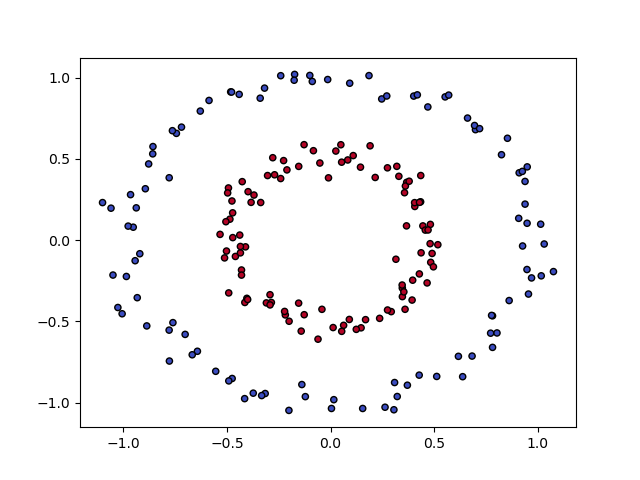

In [12]:
X,y = noisy_circles
fig, ax = plt.subplots(1,1)
ax.scatter(X[:,0], X[:,1], c=y ,cmap=plt.cm.coolwarm, s=20, edgecolors='k')

In [13]:
# ==============================
# kernels
# ==============================
GausianKernal = lambda x1,x2,sigma=1: np.exp(-1 * np.array([np.linalg.norm(x1-x, axis=1) / sigma for x in x2]))
Cosine = lambda x1,x2: (x1 @ x2.T)

# ==============================
# Function returning the specified kernel given the arguments. 
# Function follows the factory method pattern
# ==============================
def KernelFactory(f, center=False, **kwargs):
    if(center):
        return lambda x1, x2: centerKernel(f(x1,x2, **kwargs))
    return lambda x1, x2: f(x1,x2, **kwargs)

def centerKernel(K):
    return K - np.mean(K, axis=1)[:,None] - np.mean(K, axis=0)[None,:] + np.mean(K)



In [14]:
def pcaKernel(X, kernel=KernelFactory(GausianKernal, center=True, sigma=0.3), n_components=None):
    K = kernel(X,X)
    eigvals, eigvecs = np.linalg.eigh(np.around(K, decimals=10))
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]    
    if n_components is None: 
        return eigvecs,eigvals
    eigvals_trunc = np.column_stack([eigvecs[:, i] for i in range(n_components)])
    eigvecs_trunc = np.column_stack([eigvecs[:, i] for i in range(n_components)])
    print(np.sum(eigvals_trunc) / np.sum(eigvals))
    return eigvecs_trunc, eigvals_trunc


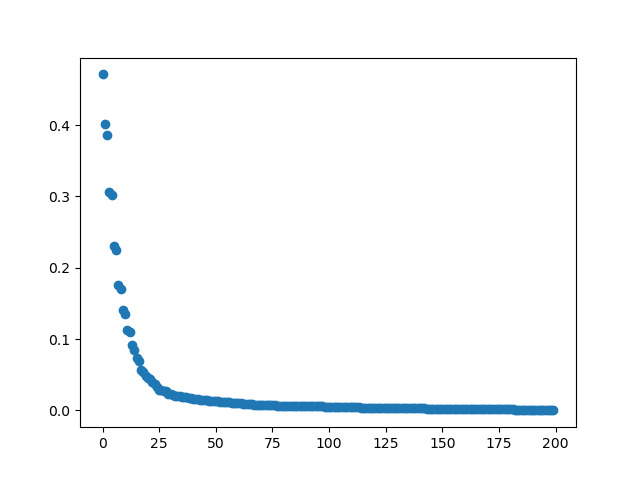

In [15]:
%matplotlib widget
X,y = noisy_moons
eigvecs,eigvals = pcaKernel(X)
weights = eigvals / np.linalg.norm(eigvals)
fig, ax = plt.subplots(1,1)
ax.scatter(np.arange(0,len(weights),1), weights);

-5.840141845545772e-15


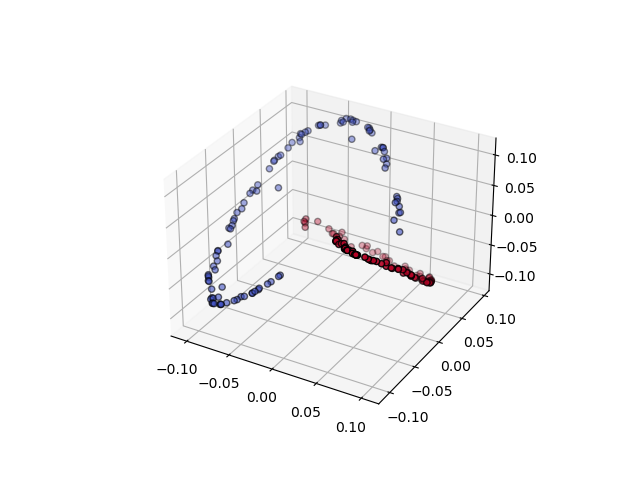

In [16]:
%matplotlib notebook
X,y = noisy_moons
eigvecs,eigvals = pcaKernel(X, n_components=3)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(eigvecs[:,0], eigvecs[:,1], eigvecs[:,2], c=y ,cmap=plt.cm.coolwarm, s=20, edgecolors='k');

-1.4937547876499842e-13


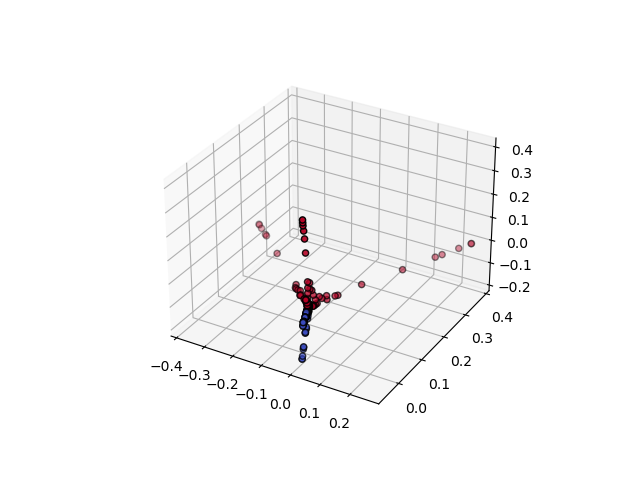

In [17]:
%matplotlib notebook
X,y = noisy_moons
eigvecs,eigvals = pcaKernel(X, KernelFactory(GausianKernal, center=True, sigma=0.05), n_components=3)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(eigvecs[:,0], eigvecs[:,1], eigvecs[:,2], c=y ,cmap=plt.cm.coolwarm, s=20, edgecolors='k')

-1.3533344107687054e-13


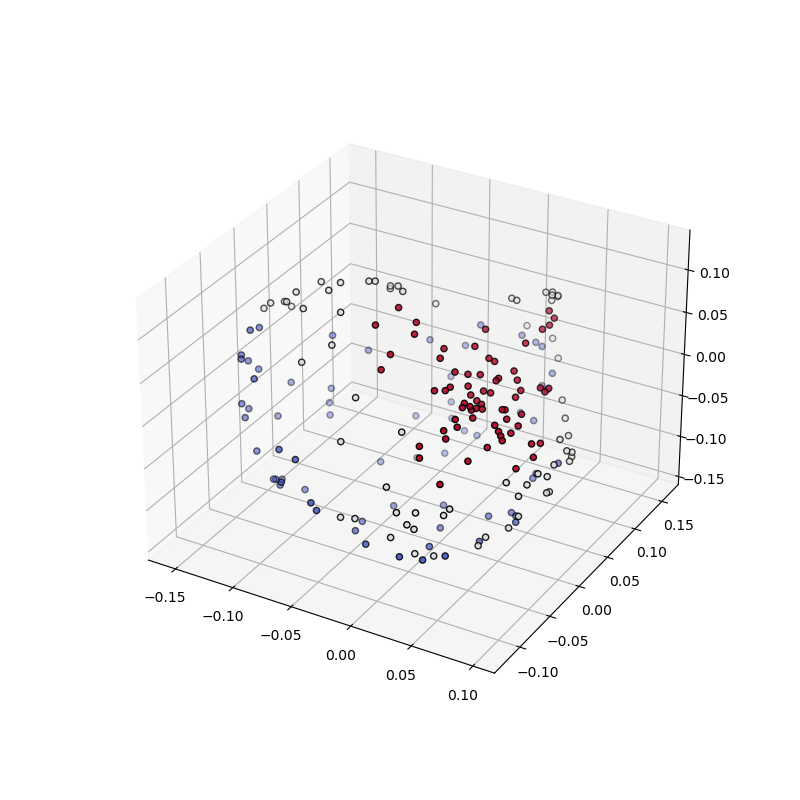

In [19]:
X,y = gaussian
eigvecs,eigvals = pcaKernel(X, KernelFactory(GausianKernal, center=True, sigma=0.5), n_components=3)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(eigvecs[:,0], eigvecs[:,1], eigvecs[:,2], c=y ,cmap=plt.cm.coolwarm, s=20, edgecolors='k')